In [1]:
import math
from pathlib import Path
import numpy as np 
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
import random

from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation,BatchNormalization, AveragePooling2D, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy, SparseCategoricalCrossentropy, MeanSquaredError


In [2]:
TRAIN_DATASET_PATH = Path("datasets/128_multilayer/train")
VALID_DATASET_PATH = Path("datasets/128_multilayer/valid")
# TRAIN_DATASET_PATH = Path("datasets/practice/train_m")
# VALID_DATASET_PATH = Path("datasets/practice/valid_m")

In [3]:
train_img_paths = list(TRAIN_DATASET_PATH.glob("**/*.bmp"))
train_ann_paths = list(TRAIN_DATASET_PATH.glob("**/*.txt"))

valid_img_paths = list(VALID_DATASET_PATH.glob("**/*.bmp"))
valid_ann_paths = list(VALID_DATASET_PATH.glob("**/*.txt"))

#valid_ann_paths

In [4]:
 num_train_samples = len(train_ann_paths)
 num_valid_samples = len(valid_img_paths)

print('num of train samples: ', num_train_samples)
print('num of valid samples: ', num_valid_samples)

num of train samples:  5780
num of valid samples:  1444


## Dataset Viewer

In [5]:
def draw_annot(image, x_0 , y_0 , gamma , conf , classes):
    plt.figure(figsize = [6,6])
    plt.imshow(image)
    plt.scatter(x_0, y_0, color='r', s=40, marker= "o")
    
    line_len = 20
    cmap = cm.get_cmap("bwr")
    for x_1,y_1,angle,confi in zip (x_0,y_0,gamma,conf):
        x_2 = x_1 + line_len*math.cos(angle)
        y_2 = y_1 + line_len*math.sin(angle)
        color_factor = confi
        plt.plot([x_1,x_2],[y_1,y_2] , c=cmap(color_factor))
    plt.colorbar()    
    plt.show

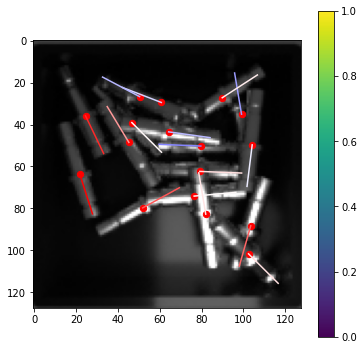

In [6]:
num = 30
Image = cv2.imread(str(train_img_paths[num]))
Annot = np.loadtxt(train_ann_paths[num])
X = Annot[:,1]
Y = Annot[:,2]
Gamma = Annot[:,3]
Conf = (Annot[:,5] + Annot[:,6])*0.5
Classes = Annot[:,0]

draw_annot(Image, X, Y, Gamma, Conf, Classes)
 

## Shuffle Samples

In [7]:
def filter_annot(annot_path, check_params=[128]):

    annot = np.loadtxt(annot_path)

    # checking for number of data points
    if annot.shape[1] != 7:
        return False

    # checking for x limits
    if (annot[:, 1].max() > 128) or (annot[:, 1].min() < 0):
        return False

    # checking for y limits
    if (annot[:, 2].max() > 128) or (annot[:, 2].min() < 0):
        return False

    return True

In [8]:
def shuffle_sample(img_paths, ann_paths):
    samples = []
    #storing image_paths and corresponding annotation paths as a pair
    for I_Path,A_Path in zip(img_paths,ann_paths):
        if filter_annot(A_Path):
            samples.append([I_Path, A_Path])
    #shuffle the sample
    random.shuffle(samples)
    return samples

In [9]:
def store_annot(i, cell_x, cell_y, index, annot, row, y_train):
    grid_w = 8
    grid_h = 8
    y_train[i, int(cell_x), int(cell_y), index, 0] = (annot[row, 1] - grid_w * int(cell_x)) / grid_w # x_0
    y_train[i, int(cell_x), int(cell_y), index, 1] = (annot[row, 2] - grid_h * int(cell_y)) / grid_h # y_0
    y_train[i, int(cell_x), int(cell_y), index, 2] = (math.sin(annot[row, 3]))**2 # I_xx
    y_train[i, int(cell_x), int(cell_y), index, 3] = (math.sin(2*annot[row, 4])+1)*0.5 #I_xy
    y_train[i, int(cell_x), int(cell_y), index, 4] = (annot[row, 5] + annot[row, 6]) * 0.5 # conf
    y_train[i, int(cell_x), int(cell_y), index, 5] = annot[row, 0] # class

    return y_train

In [10]:
def data_generator(img_paths, ann_paths, batch_size):
    grid_h = 8
    grid_w = 8
    
    #get the shuffled samples
    samples = shuffle_sample(img_paths , ann_paths)
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
    
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            x_train = np.zeros([batch_size, 128, 128, 1])
            y_train = np.zeros([batch_size, 16, 16, 3, 6])

            i=0
            for batch_sample in batch_samples:
                img_name = batch_sample[0]
                ann_name = batch_sample[1]
                
                img = cv2.imread(str(img_name),0)
                img = cv2.resize(img,(128,128))
                img = img/128

                #storing x_values back to back
                x_train[i, :, :, 0] = img

                annot = np.loadtxt(ann_name)
                #finding which grid the object belongs to      
                grid_x = annot[:,1]//grid_w
                grid_y = annot[:,2]//grid_h

                row = 0
                
                for cell_x, cell_y in zip(grid_x, grid_y):
                    if y_train[i, int(cell_x), int(cell_y), 1, 4] == 0:
                        y_train = store_annot(i, cell_x, cell_y, 1, annot, row,y_train)

                    elif y_train[i, int(cell_x), int(cell_y), 2, 4] == 0:
                        y_train = store_annot(i, cell_x, cell_y, 2, annot, row,y_train)

                    else: 
                        y_train = store_annot(i, cell_x, cell_y, 3, annot, row,y_train)
                        
                    row = row+1

                    
                i+=1

            yield x_train, y_train
                

In [11]:
train_datagen= data_generator(train_img_paths, train_ann_paths, 2)
validation_datagen= data_generator(valid_img_paths, valid_ann_paths, 2)

In [12]:
# x, y= next(validation_datagen)
# print('x_shape:', x.shape)
# print('y_shape:', y.shape)

## Creating Model

In [13]:
model = Sequential([
    Conv2D(16, (3,3),padding='same', input_shape=(128, 128, 1)),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(2,2),
    Conv2D(32, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(2,2), 
    Conv2D(18, (3,3),padding='same'),
    BatchNormalization(),
    Activation('relu'), 
    AveragePooling2D(2,2),
    Reshape((16,16,3,6)) 
    ])

In [14]:
model.compile(optimizer = Adam(lr=0.001),
              loss=MeanSquaredError(),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 128, 128, 16)      0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0

In [16]:
history =model.fit(x = train_datagen , 
                   validation_data = validation_datagen,
                   steps_per_epoch = num_train_samples,
                   validation_steps = num_valid_samples,
                   epochs=10,
                   verbose=1)

Epoch 1/10
  34/5780 [..............................] - ETA: 6:11 - loss: 0.1577 - accuracy: 0.2289

KeyboardInterrupt: 

In [ ]:
model.save("working.h5")

## Evaluating Accuracy and Loss for the Model

In [17]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc       = history.history[     'accuracy' ]
val_acc   = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc ,   label = 'training')
plt.plot  ( epochs, val_acc , label = 'validation')
plt.legend(loc = 'upper left')
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss ,    label = 'training')
plt.plot  ( epochs, val_loss , label = 'validation' )
plt.legend(loc = 'upper left')
plt.title ('Training and validation loss'   )

NameError: name 'history' is not defined

## Prediction

In [ ]:
# x_0= []
# y_0= []
# gamma= []
# conf= []
# classes= []
# for i in range(16):
#     for j in range(16):
#         if y[i,j,4] > 0.8:
#             X = y[i,j,0]*grid_w + grid_w*i
#             x_0.append(X)

#             Y = y[i,j,1]*grid+h + grid_h*j
#             y_0.append(Y)

#             #angle = #half of sin inverse of (2*y[i,j,3] - 1)
#             angle = 0.5*math.asin((2*y[i,j,3] - 1))              
#             gamma.append(angle)
#             conf.append(y[i,j,4])
#             classes.append(y[i,j,5])

In [ ]:
# def decode_yolo(output):


In [18]:
REAL_IMG_PATHS = Path("datasets/256_real_images_200")
real_img_paths = list(TRAIN_DATASET_PATH.glob("**/*.bmp"))

In [25]:
for img_path in real_img_paths[0:5]:
    img = cv2.imread(str(img_path), 0)
    img = cv2.resize(img, (128, 128))
    img = img / 128
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    out = model.predict(img)

In [29]:
reshaped = out.reshape((1, 16, 16, 18))

In [42]:
# reshaped[0, :, :, 4]

## Practice

In [ ]:
a=[1,2,3,4,5,6]
b=['a','b','c','d','f','g']
samples=[]
for x,y in zip(a,b):
    samples.append([x,y])
random.shuffle(samples)   
z=samples[0:5]
for batch in z:
    print(batch[0], batch[1])

In [ ]:
count=0
max=0
for path in valid_ann_paths:
    A=np.loadtxt(path)
    if np.max(A[:, 1]) > max:
        max = np.max(A[:,1])
        # count+=1

print(max)
# print(count)



In [ ]:
def read_annot(img_paths , ann_paths):
    samples = []
    #storing image_paths and corresponding annotation paths as a pair
    for I_Path,A_Path in zip(img_paths,ann_paths):
        annot = loadtxt(A_Path)
        
        samples.append([I_Path,A_Path])
    #shuffle the sample
    random.shuffle(samples)
    return samples


In [ ]:
# Naming convention
variable = 3


In [ ]:
128/8

In [ ]:
a = np.array([1, 3, 4, 5, 3, 1, 3, 1, 1])
b = np.array([1, 2, 4, 3, 2, 1, 6, 1, 1])
ret = np.array([0, 0, 0, 0, 1, 1, 0, 2, 3])

In [ ]:
c = np.array([[i,j] for i, j in zip(a, b)])
print(c)

In [ ]:
unique, counts = np.unique(c, axis=0, return_counts=True)
print(unique)
print(counts)

In [ ]:
np.where(unique==c[0])

In [ ]:
unique

In [ ]:
# unique, counts = np.unique(c, return_counts=True)
# dict(zip(unique, counts))

In [ ]:
from collections import Counter

In [ ]:
set(c)